In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import seaborn as sns
import re

In [46]:
members = pd.read_csv('../data/NSS_GreatCare_Members.csv', low_memory=False)
inpatient = pd.read_csv('../data/NSS_Hospital_Inpatient_Admissions.csv', low_memory=False)
pcp_visits = pd.read_csv('../data/NSS_PrimaryCare_Office_Visits.csv', low_memory=False)

In [ ]:
members.info()

In [ ]:
members1 = members[['Patient ID', 'Primary Plan ID']]

In [ ]:
members1.head()

In [53]:
#running this before creating the new inpatient df.
inpatient['Encounter Start Date'] = pd.to_datetime(inpatient['Encounter Start Date'], format='%Y-%m-%d')
inpatient['Encounter End Date'] = pd.to_datetime(inpatient['Encounter End Date'], format='%Y-%m-%d')

In [33]:
# Alternate, more efficient version of converting the dates
inpatient[['Encounter Start Date','Encounter End Date']] = inpatient[['Encounter Start Date','Encounter End Date']].apply(pd.to_datetime)

In [27]:
#Also need to convert this to datetime
pcp_visits['Encounter Date'] = pd.to_datetime(pcp_visits['Encounter Date'])

In [54]:
inpatient1=inpatient[['Encounter ID', 'Patient ID', 'Encounter Start Date', 'Encounter End Date']]

In [ ]:
inpatient1.info()

In [ ]:
pcp_visits.info()

In [ ]:
#to show all the rows:
#pd.set_option('display.max_columns', None)

# Question 1
### What is our 30-day all cause readmission rate across hospitals our members are admitted to?

In [ ]:
#Process:
#if there is a second admission date, subtract the previous visit's end date .
#Find where the time is <= 30 days

In [55]:
#first step is to sort the inpatient1 df 
inpatient1 = inpatient1.sort_values(['Patient ID',"Encounter Start Date", "Encounter End Date"], ascending = (False, True, True))

In [56]:
#THIS IS GOLD KEEP IT.  Creates columns for us to do math on and then identify rows where the patient has been admitted twice
inpatient1['Previous End Date'] = (inpatient1.groupby('Patient ID')['Encounter End Date'].shift(1))
inpatient1['Days Since Last Visit'] = inpatient1['Encounter Start Date'] - inpatient1['Previous End Date']
inpatient1 = inpatient1[inpatient1['Days Since Last Visit'].notnull()]




In [69]:
inpatient1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512 entries, 6211 to 7
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   Encounter ID           1512 non-null   object         
 1   Patient ID             1512 non-null   object         
 2   Encounter Start Date   1512 non-null   datetime64[ns] 
 3   Encounter End Date     1512 non-null   datetime64[ns] 
 4   Previous End Date      1512 non-null   datetime64[ns] 
 5   Days Since Last Visit  1512 non-null   timedelta64[ns]
dtypes: datetime64[ns](3), object(2), timedelta64[ns](1)
memory usage: 82.7+ KB


In [72]:
#Creates new dataframe where time since last visit is less than or equal to 30 days
inpatient30d = inpatient1[inpatient1['Days Since Last Visit'] <= '30 days']

inpatient30d.info()
#755 rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 6211 to 44
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   Encounter ID           755 non-null    object         
 1   Patient ID             755 non-null    object         
 2   Encounter Start Date   755 non-null    datetime64[ns] 
 3   Encounter End Date     755 non-null    datetime64[ns] 
 4   Previous End Date      755 non-null    datetime64[ns] 
 5   Days Since Last Visit  755 non-null    timedelta64[ns]
dtypes: datetime64[ns](3), object(2), timedelta64[ns](1)
memory usage: 41.3+ KB


In [ ]:
#Getting the readmission within 30 days rate:
inpatient['Patient ID'].nunique() #4701
inpatient30d['Patient ID'].nunique() #479

In [75]:
#doing the calculation
rate = inpatient30d['Patient ID'].nunique() / inpatient['Patient ID'].nunique()
print(rate) #10.18932%

0.10189321420974261


In [35]:
479/4701

0.10189321420974261

Question 1 answer is 10.18932%

## Question 1 another way

In [80]:
#give the df a new name
inviz = inpatient1
#filter out null readmissions
inviz = inviz[inviz['Days Since Last Visit'].notnull()]
#make sure the readmissions are within 30 days
inviz = inviz[inviz['Days Since Last Visit'] <= '30 days']
inviz = inviz[inviz['Days Since Last Visit'] >= '0 days']

#and then how many people was it
total_readmission = len(inviz)
total_readmission

703

In [81]:
len(inpatient)

6213

In [78]:
#using python to get the readmission rate/percentage
total_inpatients = len(inpatient)
readmission_rate = round(total_readmission/total_inpatients * 100, 2)
readmission_rate

11.31

In [ ]:
703/6213

This route gives 11.31%. 
Different from first time answering this question..

# Question2:
### What percent of patients have a PCP visit within a week of discharge?

In [ ]:
#drop duplicates! on two columns
#two_top = two_top.sort_values(['Patient ID'], ascending = (False)).drop_duplicates(['Patient ID','Encounter End Date'])

#From Brenda:
#make df and merge
ad_cut = inpatient[['Patient ID','Encounter End Date']]
pcp_cut = pcp_visits[['Patient ID','Encounter Date']]
together = ad_cut.merge(pcp_cut, left_on ='Patient ID', right_on = 'Patient ID',how='left', indicator = False)
#sort
together = together.sort_values(['Patient ID',"Encounter Date", "Encounter End Date"], ascending = (False, True, True))
#change to datetime
together['Encounter Date'] = pd.to_datetime(together['Encounter Date'], format='%Y-%m-%d')
#sub encounter date from end dates
together['Days Since Last Visit'] = together['Encounter Date'] - together['Encounter End Date']
two_top = together[together['Days Since Last Visit'] <= '7 days']
two_top = two_top[two_top['Days Since Last Visit'] >= '0 days']
two_top.rename(columns={"Encounter End Date": "Inpatient End Date"}, inplace = True)
two_top

Teng below

Process:
1. Identify patients who visited PCP within 7 days of hospital discharge
2. Identify total number of inpatient visits
3. divide answer to #1 by answer to #2

In [28]:
#Getting the relevant columns
x = inpatient[['Encounter ID','Patient ID', 'Encounter Start Date', 'Encounter End Date']]
y = pcp_visits[['Encounter ID','Patient ID', 'Encounter Date']]


In [29]:
#merge! 
inpatient_pcp= x.merge(y, how = 'left', on = 'Patient ID')
inpatient_pcp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44098 entries, 0 to 44097
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Encounter ID_x        44098 non-null  object        
 1   Patient ID            44098 non-null  object        
 2   Encounter Start Date  44098 non-null  datetime64[ns]
 3   Encounter End Date    44098 non-null  datetime64[ns]
 4   Encounter ID_y        43791 non-null  object        
 5   Encounter Date        43791 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 2.4+ MB


In [31]:
#Time between leaving hospital and visiting PCP as a new column

inpatient_pcp['7_Days'] = inpatient_pcp['Encounter Date'] - inpatient_pcp['Encounter End Date']

In [32]:
#Who visited their PCP within 7 days

# Looping through the time difference column to find any that are within 7days. 

t = []

for i in inpatient_pcp['7_Days']:
    if (i <= dt.timedelta(days=7)) and (i >= dt.timedelta(days=0)) :
        t.append('yes')
    else:
        t.append('no')

In [37]:
# Adding the list 't' as a new column 

inpatient_pcp['within_7'] = t

inpatient_pcp

,Encounter ID_x,Patient ID,Encounter Start Date,Encounter End Date,Encounter ID_y,Encounter Date,7_Days,within_7
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1228384|1043427248|1|SHIFTED,2015-12-08,1058 days,no
1,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|1326684|1043427248|1|SHIFTED,2012-06-18,-210 days,no
2,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|155317|1043427248|1|SHIFTED,2014-06-10,512 days,no
3,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|439093|1043427248|1|SHIFTED,2014-09-28,622 days,no
4,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,2013-01-12,2013-01-14,COV|PBSL|DS1|10033|P|711310|1043427248|1|SHIFTED,2014-03-16,426 days,no
...,...,...,...,...,...,...,...,...
44093,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|1238517|1407058787|2,2015-12-05,8 days,no
44094,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|302749|1407058787|2,2015-12-13,16 days,no
44095,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|781849|1205884392|1,2014-05-18,-558 days,no
44096,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,COV|PCSL|DS1|9994|P|93182|1043427248|1,2013-07-20,-860 days,no


In [38]:
#Get the counts of within_7 column
inpatient_pcp['within_7'].value_counts()

no     41723
yes     2375
Name: within_7, dtype: int64

### Dealing with duplicates (patients who saw their PCP more than once within the 7 days after discharge)

In [40]:
#focus on the 'yes' from the 'within_7' column
yes = inpatient_pcp.loc[inpatient_pcp['within_7'] == 'yes']
type(yes)

pandas.core.frame.DataFrame

In [42]:
#remove duplicates from the yes ('Encounter ID_x' is from the inpatient visits - just count that and not multiple PCP visits)
yes = yes.drop_duplicates(subset='Encounter ID_x', keep='first')
yes #1864 rows (visits to PCP within 7 days)

,Encounter ID_x,Patient ID,Encounter Start Date,Encounter End Date,Encounter ID_y,Encounter Date,7_Days,within_7
17,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,2014-01-05,2014-01-12,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,2014-01-12,0 days,yes
28,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,2012-06-13,2012-06-21,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,2012-06-27,6 days,yes
50,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,2012-12-06,2012-12-09,COV|PCSL|DS1|10101|P|1189971|1043427248|1,2012-12-12,3 days,yes
231,HIA|DS1|10303|DS1|NPI|1710918545|1,DS1|10303,2012-06-21,2012-06-24,COV|PBSL|DS1|10303|P|10896|1912987553|1,2012-06-30,6 days,yes
247,HIA|DS1|10305|DS1|NPI|1184722779|1,DS1|10305,2014-05-10,2014-05-12,COV|PBSL|DS1|10305|P|823298|1184722779|1,2014-05-13,1 days,yes
...,...,...,...,...,...,...,...,...
44039,HIA|DS1|9943|DS1|NPI|1184722779|3,DS1|9943,2014-10-28,2014-10-30,COV|PCSL|DS1|9943|P|1315984|1184722779|1,2014-11-03,4 days,yes
44051,HIA|DS1|9945|DS1|NPI|1902803315|1,DS1|9945,2013-02-09,2013-02-11,COV|PCSL|DS1|9945|P|840374|1043427248|1,2013-02-14,3 days,yes
44067,HIA|DS1|9978|DS1|NPI|1427055839|1,DS1|9978,2015-09-01,2015-09-05,COV|PCSL|DS1|9978|P|696226|1043427248|1,2015-09-11,6 days,yes
44071,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,2015-02-06,2015-02-11,COV|PCSL|DS1|9979|P|281365|1477666352|1,2015-02-15,4 days,yes


1864 patients visited their PCP within 7 days of hospital discharge.

In [43]:
#how many total inpatient visits were there?
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Encounter ID          6213 non-null   object        
 1   Patient ID            6213 non-null   object        
 2   Encounter Start Date  6213 non-null   datetime64[ns]
 3   Encounter End Date    6213 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 194.3+ KB


In [44]:
#1864 patients / 6213 inpatients
1864/6213

0.30001609528408174

# Question 3 
Do either vary by individual or group PCP's?

# Playing Around

In [ ]:
------- gonna try and visualize something

In [82]:
inpatient1.head()

,Encounter ID,Patient ID,Encounter Start Date,Encounter End Date,Previous End Date,Days Since Last Visit
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,2015-11-23,1 days
6202,HIA|DS1|9943|DS1|NPI|1184722779|2,DS1|9943,2013-10-25,2013-10-28,2013-10-16,9 days
6203,HIA|DS1|9943|DS1|NPI|1184722779|3,DS1|9943,2014-10-28,2014-10-30,2013-10-28,365 days
6199,HIA|DS1|9935|DS1|NPI|1902803315|1,DS1|9935,2011-01-25,2011-01-26,2011-01-24,1 days
6197,HIA|DS1|9935|DS1|NPI|1366401333|1,DS1|9935,2011-01-26,2011-02-07,2011-01-26,0 days


In [83]:
#break out new columns for year and month
inpatient1['year'] = pd.DatetimeIndex(inpatient1['Previous End Date']).year
inpatient1['month'] = pd.DatetimeIndex(inpatient1['Previous End Date']).month
inpatient1.head()

,Encounter ID,Patient ID,Encounter Start Date,Encounter End Date,Previous End Date,Days Since Last Visit,year,month
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,2015-11-24,2015-11-27,2015-11-23,1 days,2015,11
6202,HIA|DS1|9943|DS1|NPI|1184722779|2,DS1|9943,2013-10-25,2013-10-28,2013-10-16,9 days,2013,10
6203,HIA|DS1|9943|DS1|NPI|1184722779|3,DS1|9943,2014-10-28,2014-10-30,2013-10-28,365 days,2013,10
6199,HIA|DS1|9935|DS1|NPI|1902803315|1,DS1|9935,2011-01-25,2011-01-26,2011-01-24,1 days,2011,1
6197,HIA|DS1|9935|DS1|NPI|1366401333|1,DS1|9935,2011-01-26,2011-02-07,2011-01-26,0 days,2011,1


In [89]:
#How many under-30-days readmissions do we get, by month
by_month = inpatient1.groupby(['year','month'], as_index=False).count()
by_month = by_month.sort_values(['year','month','Patient ID'], ascending = (True, True,False))

In [90]:
by_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   year                   104 non-null    int64
 1   month                  104 non-null    int64
 2   Encounter ID           104 non-null    int64
 3   Patient ID             104 non-null    int64
 4   Encounter Start Date   104 non-null    int64
 5   Encounter End Date     104 non-null    int64
 6   Previous End Date      104 non-null    int64
 7   Days Since Last Visit  104 non-null    int64
dtypes: int64(8)
memory usage: 7.3 KB


In [92]:
mean = by_month['Encounter ID'].mean

TypeError: '>' not supported between instances of 'float' and 'method'

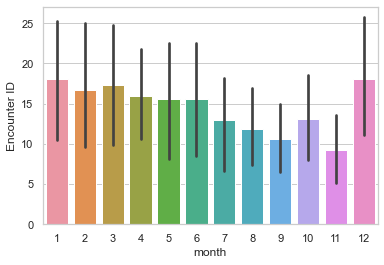

In [93]:
sns.set_theme(style="whitegrid")
ax1 = sns.barplot(x='month', y='Encounter ID',  data=by_month)
ax1.axhline(mean, color='r', linestyle='--', label="Mean")
_=ax1.legend()